$G_i + P \quad[k^{b_P}_i]<->[k^{u_P}_i] \quad  G_i:P \\
G_i:P \quad  --> [k_i^{tx}] \quad  G_i + P + T_i \\
T_i + R \quad  [k^{b_R}_i]<->[k^{u_R}_i]\quad   T_i:R \\
T_i:R  \quad -->[k_i^{tl}]\quad T_i + R + X_i \\
T_i + E \quad  [k^{b_E}_i]<->[k^{u_E}_i] \quad  T_i:E \\
T_i:E \quad-->[\delta_i]\quad E \\
T \quad-->[d_T]\quad \\
X \quad-->[d]\quad $

In [2]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from autoreduce import *
import numpy as np
from sympy import symbols

In [3]:
# Post conservation law and other approximations phenomenological model at the RNA level
n = 8 # Number of states : P, C1, T, R, C2, E, C3, X
nouts = 1 # Number of outputs, X_i

# Inputs by user 
x_init = np.zeros(n)
x_init[0] = 100
x_init[3] = 400
x_init[5] = 20
C = np.zeros((nouts,n), dtype=int)
C[0][7] = 1

nstates_tol_max = 3
nsatees_tol_min = 2
error_tol = 3000
# System dynamics symbolically

# k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d = params, len(params) = 10


x0 = symbols('P')
x1 = symbols('C1') # G:P
x2 = symbols('T')
x3 = symbols('R')
x4 = symbols('C2') # T:R
x5 = symbols('E')
x6 = symbols('C3') # T:E
x7 = symbols('X')

x = [x0, x1, x2, x3, x4, x5, x6, x7]

G = symbols('G')
k_bp = symbols('k_bp')
k_up = symbols('k_up')
k_tx = symbols('k_tx')
k_br = symbols('k_br')
k_ur = symbols('k_ur')
k_tl = symbols('k_tl')
k_be = symbols('k_be')
k_ue = symbols('k_ue')
d_i = symbols('d_i')
d = symbols('d')
d_T = symbols('d_T')

E_tot = symbols('E_tot')
P_tot = symbols('P_tot')
R_tot = symbols('R_tot')
params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, d_T, E_tot, P_tot, R_tot, G]
# f0 = (k_bp + k_tx) * x1 - k_up * G * x0
f0 = (k_up + k_tx) * x1 - k_bp * G * x0
f1 = k_bp * G * x0 - (k_up + k_tx)*x1
f2 = k_tx * x1 + (k_ur + k_tl) * x4 + k_ue * x6 - k_br * x2 * x3 - k_be * x2 * x5 - d_T * x2
f3 = (k_ur + k_tl) * x4 - k_br * x2 * x3
f4 = k_br * x2 * x3 - (k_ur + k_tl) * x4
f5 = (k_ue + d_i) * x6 - k_be * x2 * x5
f6 = k_be * x2 * x5 - (k_ue + d_i) * x6
f7 = k_tl * x4 - d * x7
    
f = [f0,f1,f2,f3,f4,f5,f6,f7]
# parameter values
# E_tot = 20
# P_tot = 100
# R_tot = 400
params_values = [80, 2, 0.50, 80, 2, 0.5, 10, 2, 0.1, 0.5, 0.01, 100, 100, 400, 10]
# params_values = [100, 10, 4, 10, 0.25, 2, 10, 0.5, 1, 1, 1000, 1000, 1000, 10]
sys = System(x, f, params = params, params_values = params_values, C = C, x_init = x_init)

In [4]:
from autoreduce.utils import get_ODE
timepoints_ode = np.linspace(0, 24, 100)
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system().T
try:
    import matplotlib.pyplot as plt
    plt.plot(timepoints_ode, np.transpose(np.array(C)@sol));
    plt.xlabel('Time');
    plt.ylabel('[Outputs]');
    plt.show();
except:
    print('Plotting libraries missing.')

Text(0.5, 0, 'Time')

Text(0, 0.5, '[Outputs]')

<Figure size 640x480 with 1 Axes>

In [5]:
from autoreduce.utils import get_reducible
timepoints_ssm = np.linspace(0,2,10)
timepoints_ode = np.linspace(0,2,100)
sys_reduce = get_reducible(sys, timepoints_ode, timepoints_ssm)
sys_reduce.nstates_tol_min = 2
sys_reduce.nstates_tol_max = 3

In [6]:
P, C1, T, R, C2, E, C3, X = sys.x
conserved_quantities = [P + C1 - P_tot, R + C2 - R_tot, E + C3 - E_tot]
states_to_eliminate = [C1, C2, C3]
f_cons = sys_reduce.set_conservation_laws(conserved_quantities, states_to_eliminate)

In [7]:
f_cons

[-G*P*k_bp + (-P + P_tot)*(k_tx + k_up),
 -E*T*k_be - R*T*k_br - T*d_T + k_tx*(-P + P_tot) + k_ue*(-E + E_tot) + (-R + R_tot)*(k_tl + k_ur),
 -R*T*k_br + (-R + R_tot)*(k_tl + k_ur),
 -E*T*k_be + (-E + E_tot)*(d_i + k_ue),
 -X*d + k_tl*(-R + R_tot)]

Text(0.5, 0, 'Time')

Text(0, 0.5, '[X]')

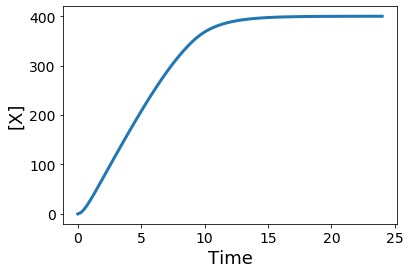

In [8]:
from autoreduce.utils import get_ODE
timepoints_ode = np.linspace(0, 24, 100)
# params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, E_tot, P_tot, R_tot, G]
# params_values = [100, 10, 4, 10, 0.25, 2, 10, 0.5, 1, 10, 10000, 10000, 10000, 0.01]
# params_values = [30, 10, 0.50, 80, 2, 8, 10, 2, 1, 0.5, 0.01, 20, 100, 400, 10]
# sys_reduce.params_values = params_values
sys_ode = get_ODE(sys_reduce, timepoints_ode)
sol = sys_ode.solve_system().T
try:
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    plt.plot(timepoints_ode, np.transpose(np.array(sys_reduce.C)@sol), linewidth = 3)
    plt.xlabel('Time', FontSize = 18)
    plt.ylabel('[X]', FontSize = 18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    # plt.legend()
    plt.show()
except:
    print('Plotting libraries missing.')

In [9]:
sys_reduce.f

[-G*P*k_bp + (-P + P_tot)*(k_tx + k_up),
 -E*T*k_be - R*T*k_br - T*d_T + k_tx*(-P + P_tot) + k_ue*(-E + E_tot) + (-R + R_tot)*(k_tl + k_ur),
 -R*T*k_br + (-R + R_tot)*(k_tl + k_ur),
 -E*T*k_be + (-E + E_tot)*(d_i + k_ue),
 -X*d + k_tl*(-R + R_tot)]

In [10]:
sys_reduce.x

[P, T, R, E, X]

In [11]:
reduced_sys_trx, fast_ss = sys_reduce.solve_timescale_separation([T, R, X], fast_states = [P, E], debug = False)


Successful time-scale separation solution obtained with states: [T, R, X]!


In [12]:
reduced_sys_trx.f[0]

-E_tot*T*k_be*(d_i + k_ue)/(T*k_be + d_i + k_ue) - R*T*k_br - T*d_T + k_tx*(-P_tot*(k_tx + k_up)/(G*k_bp + k_tx + k_up) + P_tot) + k_ue*(-E_tot*(d_i + k_ue)/(T*k_be + d_i + k_ue) + E_tot) + (-R + R_tot)*(k_tl + k_ur)

# Reduced model (obtained using time-scale separation above) vs Full model

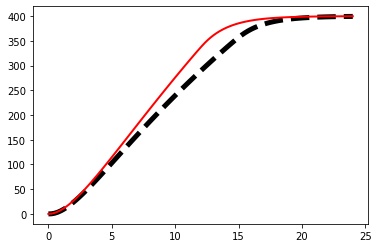

In [13]:
reduced_sys = reduced_sys_trx
try:
    fig, ax = plt.subplots() 
    # params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, d_T, E_tot, P_tot, R_tot, G]
    params_values_new = [80, 2, 0.5, 80, 2, 0.5, 8, 0.2, 0.1, 0.5, 0.05, 100, 100, 400, 0.1]
    # Set new parameters 
    sys.params_values = params_values_new
    reduced_sys.params_values = params_values_new
    # Set new initial conditions 
    sys.x_init[0] = params_values_new[-3]
    sys.x_init[3] = params_values_new[-2]
    sys.x_init[5] = params_values_new[-4]
    if P in reduced_sys.x:
        ind = reduced_sys.x.index(P)
        reduced_sys.x_init[ind] = params_values[-3]
    if R in reduced_sys.x:
        ind = reduced_sys.x.index(R)
        reduced_sys.x_init[ind] = params_values[-2]
    if E in reduced_sys.x:
        ind = reduced_sys.x.index(E)
        reduced_sys.x_init[ind] = params_values[-4]
    # Solve ODEs and plot
    sys_ode = get_ODE(sys, timepoints_ode)
    sol = sys_ode.solve_system().T
    _ = plt.plot(timepoints_ode, np.transpose(np.array(sys.C)@sol), 'k--', label = 'Full CRN model', linewidth = 5)
    reduced_ode = get_ODE(reduced_sys, timepoints_ode)
    reduced_sol = reduced_ode.solve_system().T
    _ = plt.plot(timepoints_ode, np.transpose(np.array(reduced_sys.C)@reduced_sol), 'r', label = 'Reduced model', linewidth = 2)
    
    plt.savefig('trx.svg')
    plt.show()
except:
    print('Plotting libraries missing.')

# Robustness [T, R, X]

In [20]:
Se_trx = sys_reduce.get_robustness_metric(reduced_sys_trx)

SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete
SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete


C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\linalg\_solvers.py:196: RuntimeWarning: Input "a" has an eigenvalue pair whose sum is very close to or exactly zero. The solution is obtained via perturbing the coefficients.
  RuntimeWarning)


c:\users\apand\box\biocircuits\ayush\synbio\autoreduce\autoreduce\model_reduction.py:238: ComplexWarning: Casting complex values to real discards the imaginary part
  Se[j] = max_eig_P + 2*len(reduced_ssm.timepoints)*S_metric_max + dot_P_term


Robustness Metric Progress: |██████████████████████████████████████████████████| 100.0% Complete


# [T, X] model

In [22]:
reduced_sys_tx, fast_ss = sys_reduce.solve_timescale_separation([T, X], fast_states = [P, R, E], debug = False)


Successful time-scale separation solution obtained with states: [T, X]!


In [23]:
Se_tx = sys_reduce.get_robustness_metric(reduced_sys_tx)

SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete
SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete
Robustness Metric Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [24]:
reduced_sys_tex, fast_ss = sys_reduce.solve_timescale_separation([T, E, X], fast_states = [P, R], debug = False)


Successful time-scale separation solution obtained with states: [T, E, X]!


In [25]:
Se_tex = sys_reduce.get_robustness_metric(reduced_sys_tex)

SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete
SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete
Robustness Metric Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [26]:
reduced_sys_prx, fast_ss = sys_reduce.solve_timescale_separation([P, R, X], fast_states = [T, E], debug = False)


Successful time-scale separation solution obtained with states: [P, R, X]!


In [27]:
Se_prx = sys_reduce.get_robustness_metric(reduced_sys_prx)

SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete
SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete
Robustness Metric Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [28]:
reduced_sys_ptx, fast_ss = sys_reduce.solve_timescale_separation([P, T, X], fast_states = [R, E], debug = False)


Successful time-scale separation solution obtained with states: [P, T, X]!


In [29]:
Se_ptx = sys_reduce.get_robustness_metric(reduced_sys_ptx)

SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete
SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete
Robustness Metric Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [30]:
reduced_sys_rex, fast_ss = sys_reduce.solve_timescale_separation([R, E, X], fast_states = [P, T], debug = False)


Successful time-scale separation solution obtained with states: [R, E, X]!


In [31]:
Se_rex = sys_reduce.get_robustness_metric(reduced_sys_rex)

SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete
SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete
Robustness Metric Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [32]:
list_reduced_sys = [reduced_sys_tx, reduced_sys_trx, reduced_sys_tex, reduced_sys_ptx, reduced_sys_rex]
list_Se = [Se_tx, Se_trx, Se_tex, Se_ptx, Se_rex]
results = {}
for sys_i, Se_i in zip(list_reduced_sys, list_Se):
    results[sys_i] = [0, Se_i]

In [33]:
results

{<autoreduce.system.System at 0x1fff7257240>: [0,
  array([4.01010552e+00, 4.00190311e+00, 4.00045764e+00, 4.01524248e+00,
         4.02930535e+00, 1.33032194e+03, 4.00063837e+00, 4.00253744e+00,
         4.00029480e+00, 7.12978562e+05, 4.00000180e+00, 4.01821795e+00,
         4.00071742e+00, 4.73181094e+02, 4.00180321e+00])],
 <autoreduce.system.System at 0x1fff728de48>: [0,
  array([2.34797304e+14, 1.06001240e+17, 6.80058919e+17, 2.67590553e+16,
         2.19708962e+17, 9.65207085e+15, 3.79110429e+16, 4.19550099e+16,
         6.12252762e+16, 1.46880080e+16, 1.04076100e+17, 9.15204508e+16,
         3.15062972e+16, 1.75632793e+16, 6.06933058e+17])],
 <autoreduce.system.System at 0x1fff728d828>: [0,
  array([1.02582593e+15, 5.70223611e+17, 4.10266873e+18, 1.41079850e+18,
         1.64965843e+18, 5.19174398e+16, 2.35612025e+17, 2.21166126e+17,
         1.03221762e+19, 1.66635739e+17, 6.05365149e+17, 4.12377641e+18,
         1.69468548e+17, 8.42525662e+14, 3.26126391e+18])],
 <autoreduce.

# Limited Resource - RNAP (strict)

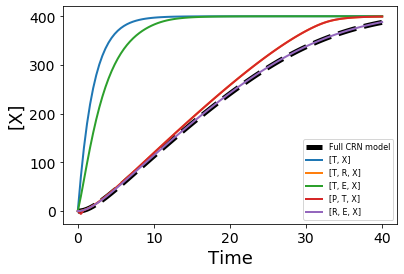

In [304]:
fig, ax = plt.subplots() 
count = 0
# params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, d_T, E_tot, P_tot, R_tot, G]
# params_values = [80, 2, 0.50, 80, 2, 0.5, 10, 2, 0.1, 0.5, 0.01, 100, 100, 400, 10]

params_values_new = [80, 2, 0.50, 80, 2, 0.5, 10, 2, 0.1, 0.5, 0.01, 100, 40, 400, 0.1]
sys.params_values = params_values_new
sys.x_init[0] = params_values_new[-3]
sys.x_init[3] = params_values_new[-2]
sys.x_init[5] = params_values_new[-4]
# print(sys.x_init)
timepoints_ode = np.linspace(0,40,100)
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system().T
_ = plt.plot(timepoints_ode, np.transpose(np.array(sys.C)@sol), 'k--', label = 'Full CRN model', linewidth = 5)
for key,value in results.items():
#     error = value[0]
#     if error > 1e-5:
    sys_i = key
    sys_i.params_values = params_values_new
    if P in sys_i.x:
        ind = sys_i.x.index(P)
        sys_i.x_init[ind] = params_values[-3]
    if R in sys_i.x:
        ind = sys_i.x.index(R)
        sys_i.x_init[ind] = params_values[-2]
    if E in sys_i.x:
        ind = sys_i.x.index(E)
        sys_i.x_init[ind] = params_values[-4]
    if len(sys_i.x) >=4:
        continue
#         _ = plt.subplots(count%3, count%3)
    sys_i_ode = get_ODE(sys_i, timepoints_ode)
    sol_i = sys_i_ode.solve_system().T
    _ = plt.plot(timepoints_ode, np.transpose(sys_i.C@sol_i), label = str(sys_i.x), linewidth = 2)
    _ = plt.xlabel('Time', FontSize = 18)
    _ = plt.ylabel('[X]', FontSize = 18)
    _ = ax.tick_params(axis='both', which='major', labelsize=14)
    _ = plt.legend(prop={'size': 8})
    count += 1

# _ = plt.axvline(x=timepoints_ode[6], color = 'k',linestyle = ':',linewidth = 1.5)
# _ = plt.axvline(x=timepoints_ode[15], color = 'k',linestyle = ':',linewidth = 1.5)
# _ = plt.axvline(x=timepoints_ode[30], color = 'k',linestyle = ':',linewidth = 1.5)
_ = plt.savefig('resource_strict.svg')
plt.show()


# Limited Resource - RNAP (mild)

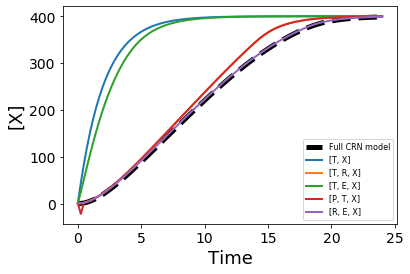

In [369]:
fig, ax = plt.subplots() 
count = 0
# params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, d_T, E_tot, P_tot, R_tot, G]
# params_values = [80, 2, 0.50, 80, 2, 0.5, 10, 2, 0.1, 0.5, 0.01, 100, 100, 400, 10]

params_values_new = [80, 2, 0.50, 80, 2, 0.5, 10, 2, 0.1, 0.5, 0.01, 100, 80, 400, 0.1]
sys.params_values = params_values_new
sys.x_init[0] = params_values_new[-3]
sys.x_init[3] = params_values_new[-2]
sys.x_init[5] = params_values_new[-4]
# print(sys.x_init)
timepoints_ode = np.linspace(0,24,100)
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system().T
_ = plt.plot(timepoints_ode, np.transpose(np.array(sys.C)@sol), 'k--', label = 'Full CRN model', linewidth = 5)
for key,value in results.items():
    sys_i = key
    sys_i.params_values = params_values_new
    if P in sys_i.x:
        ind = sys_i.x.index(P)
        sys_i.x_init[ind] = params_values[-3]
    if R in sys_i.x:
        ind = sys_i.x.index(R)
        sys_i.x_init[ind] = params_values[-2]
    if E in sys_i.x:
        ind = sys_i.x.index(E)
        sys_i.x_init[ind] = params_values[-4]
    if len(sys_i.x) >=4:
        continue
    sys_i_ode = get_ODE(sys_i, timepoints_ode)
    sol_i = sys_i_ode.solve_system().T
    _ = plt.plot(timepoints_ode, np.transpose(sys_i.C@sol_i), label = str(sys_i.x), linewidth = 2)
    _ = plt.xlabel('Time', FontSize = 18)
    _ = plt.ylabel('[X]', FontSize = 18)
    _ = ax.tick_params(axis='both', which='major', labelsize=14)
    _ = plt.legend(prop={'size': 8})
    count += 1

# _ = plt.axvline(x=timepoints_ode[6], color = 'k',linestyle = ':',linewidth = 1.5)
# _ = plt.axvline(x=timepoints_ode[15], color = 'k',linestyle = ':',linewidth = 1.5)
# _ = plt.axvline(x=timepoints_ode[30], color = 'k',linestyle = ':',linewidth = 1.5)
_ = plt.savefig('resource_mild.svg')
plt.show()


# Unlimited resources

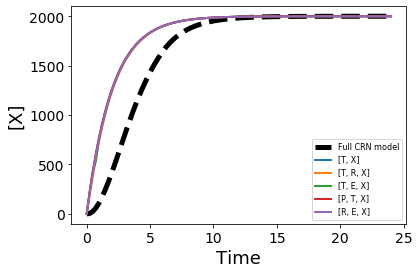

In [364]:
fig, ax = plt.subplots() 
count = 0
# params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, d_T, E_tot, P_tot, R_tot, G]
# params_values = [80, 2, 0.50, 80, 2, 0.5, 10, 2, 0.1, 0.5, 0.01, 100, 100, 400, 10]

params_values_new = [80, 2, 0.50, 80, 2, 0.5, 10, 2, 0.1, 0.5, 0.01, 2000, 2000, 2000, 0.1]
sys.params_values = params_values_new
sys.x_init[0] = params_values_new[-3]
sys.x_init[3] = params_values_new[-2]
sys.x_init[5] = params_values_new[-4]
# print(sys.x_init)
timepoints_ode = np.linspace(0,24,100)
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system().T
_ = plt.plot(timepoints_ode, np.transpose(np.array(sys.C)@sol), 'k--', label = 'Full CRN model', linewidth = 5)
for key,value in results.items():
    sys_i = key
    sys_i.params_values = params_values_new
    if P in sys_i.x:
        ind = sys_i.x.index(P)
        sys_i.x_init[ind] = params_values[-3]
    if R in sys_i.x:
        ind = sys_i.x.index(R)
        sys_i.x_init[ind] = params_values[-2]
    if E in sys_i.x:
        ind = sys_i.x.index(E)
        sys_i.x_init[ind] = params_values[-4]
    if len(sys_i.x) >=4:
        continue
    sys_i_ode = get_ODE(sys_i, timepoints_ode)
    sol_i = sys_i_ode.solve_system().T
    _ = plt.plot(timepoints_ode, np.transpose(sys_i.C@sol_i), label = str(sys_i.x), linewidth = 2)
    _ = plt.xlabel('Time', FontSize = 18)
    _ = plt.ylabel('[X]', FontSize = 18)
    _ = ax.tick_params(axis='both', which='major', labelsize=14)
    _ = plt.legend(prop={'size': 8})
    count += 1

# _ = plt.axvline(x=timepoints_ode[6], color = 'k',linestyle = ':',linewidth = 1.5)
# _ = plt.axvline(x=timepoints_ode[15], color = 'k',linestyle = ':',linewidth = 1.5)
# _ = plt.axvline(x=timepoints_ode[30], color = 'k',linestyle = ':',linewidth = 1.5)
_ = plt.savefig('resource_unlimited.svg')
plt.show()


# RBS strength (very weak)

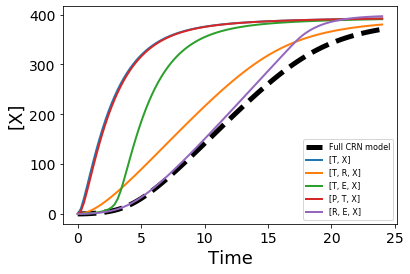

In [356]:
fig, ax = plt.subplots() 
count = 0
# params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, d_T, E_tot, P_tot, R_tot, G]
# params_values = [80, 2, 0.50, 80, 2, 0.5, 10, 2, 0.1, 0.5, 0.01, 100, 100, 400, 10]

params_values_new = [80, 2, 0.50, 0.4, 4, 0.5, 10, 2, 0.1, 0.5, 0.01, 100, 100, 400, 0.1]
sys.params_values = params_values_new
sys.x_init[0] = params_values_new[-3]
sys.x_init[3] = params_values_new[-2]
sys.x_init[5] = params_values_new[-4]
# print(sys.x_init)
timepoints_ode = np.linspace(0,24,100)
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system().T
_ = plt.plot(timepoints_ode, np.transpose(np.array(sys.C)@sol), 'k--', label = 'Full CRN model', linewidth = 5)
for key,value in results.items():
    sys_i = key
    sys_i.params_values = params_values_new
    if P in sys_i.x:
        ind = sys_i.x.index(P)
        sys_i.x_init[ind] = params_values[-3]
    if R in sys_i.x:
        ind = sys_i.x.index(R)
        sys_i.x_init[ind] = params_values[-2]
    if E in sys_i.x:
        ind = sys_i.x.index(E)
        sys_i.x_init[ind] = params_values[-4]
    if len(sys_i.x) >=4:
        continue
    sys_i_ode = get_ODE(sys_i, timepoints_ode)
    sol_i = sys_i_ode.solve_system().T
    _ = plt.plot(timepoints_ode, np.transpose(sys_i.C@sol_i), label = str(sys_i.x), linewidth = 2)
    _ = plt.xlabel('Time', FontSize = 18)
    _ = plt.ylabel('[X]', FontSize = 18)
    _ = ax.tick_params(axis='both', which='major', labelsize=14)
    _ = plt.legend(prop={'size': 8})
    count += 1

# _ = plt.axvline(x=timepoints_ode[6], color = 'k',linestyle = ':',linewidth = 1.5)
# _ = plt.axvline(x=timepoints_ode[15], color = 'k',linestyle = ':',linewidth = 1.5)
# _ = plt.axvline(x=timepoints_ode[30], color = 'k',linestyle = ':',linewidth = 1.5)
_ = plt.savefig('rbs_very_weak.svg')
plt.show()


# RBS weak (mild)

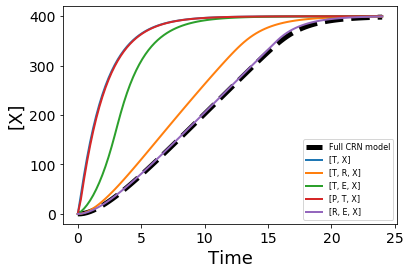

In [355]:
fig, ax = plt.subplots() 
count = 0
# params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, d_T, E_tot, P_tot, R_tot, G]
# params_values = [80, 2, 0.50, 80, 2, 0.5, 10, 2, 0.1, 0.5, 0.01, 100, 100, 400, 10]

params_values_new = [80, 2, 0.50, 10, 4, 0.5, 10, 2, 0.1, 0.5, 0.01, 100, 100, 400, 0.1]
sys.params_values = params_values_new
sys.x_init[0] = params_values_new[-3]
sys.x_init[3] = params_values_new[-2]
sys.x_init[5] = params_values_new[-4]
# print(sys.x_init)
timepoints_ode = np.linspace(0,24,100)
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system().T
_ = plt.plot(timepoints_ode, np.transpose(np.array(sys.C)@sol), 'k--', label = 'Full CRN model', linewidth = 5)
for key,value in results.items():
    sys_i = key
    sys_i.params_values = params_values_new
    if P in sys_i.x:
        ind = sys_i.x.index(P)
        sys_i.x_init[ind] = params_values[-3]
    if R in sys_i.x:
        ind = sys_i.x.index(R)
        sys_i.x_init[ind] = params_values[-2]
    if E in sys_i.x:
        ind = sys_i.x.index(E)
        sys_i.x_init[ind] = params_values[-4]
    if len(sys_i.x) >=4:
        continue
    sys_i_ode = get_ODE(sys_i, timepoints_ode)
    sol_i = sys_i_ode.solve_system().T
    _ = plt.plot(timepoints_ode, np.transpose(sys_i.C@sol_i), label = str(sys_i.x), linewidth = 2)
    _ = plt.xlabel('Time', FontSize = 18)
    _ = plt.ylabel('[X]', FontSize = 18)
    _ = ax.tick_params(axis='both', which='major', labelsize=14)
    _ = plt.legend(prop={'size': 8})
    count += 1

# _ = plt.axvline(x=timepoints_ode[6], color = 'k',linestyle = ':',linewidth = 1.5)
# _ = plt.axvline(x=timepoints_ode[15], color = 'k',linestyle = ':',linewidth = 1.5)
# _ = plt.axvline(x=timepoints_ode[30], color = 'k',linestyle = ':',linewidth = 1.5)
_ = plt.savefig('rbs_weak_mild.svg')
plt.show()


# Polymerase very weak 

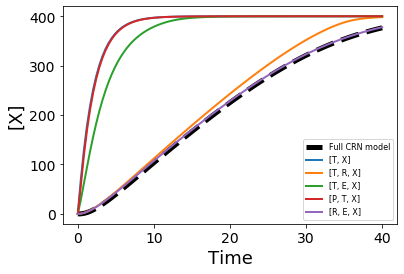

In [370]:
fig, ax = plt.subplots() 
count = 0
# params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, d_T, E_tot, P_tot, R_tot, G]
# params_values = [80, 2, 0.50, 80, 2, 0.5, 10, 2, 0.1, 0.5, 0.01, 100, 100, 400, 10]

params_values_new = [10, 2, 0.50, 80, 2, 0.5, 10, 2, 0.1, 0.5, 0.01, 100, 100, 400, 0.1]
sys.params_values = params_values_new
sys.x_init[0] = params_values_new[-3]
sys.x_init[3] = params_values_new[-2]
sys.x_init[5] = params_values_new[-4]
# print(sys.x_init)
timepoints_ode = np.linspace(0,40,100)
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system().T
_ = plt.plot(timepoints_ode, np.transpose(np.array(sys.C)@sol), 'k--', label = 'Full CRN model', linewidth = 5)
for key,value in results.items():
    sys_i = key
    sys_i.params_values = params_values_new
    if P in sys_i.x:
        ind = sys_i.x.index(P)
        sys_i.x_init[ind] = params_values[-3]
    if R in sys_i.x:
        ind = sys_i.x.index(R)
        sys_i.x_init[ind] = params_values[-2]
    if E in sys_i.x:
        ind = sys_i.x.index(E)
        sys_i.x_init[ind] = params_values[-4]
    if len(sys_i.x) >=4:
        continue
    sys_i_ode = get_ODE(sys_i, timepoints_ode)
    sol_i = sys_i_ode.solve_system().T
    _ = plt.plot(timepoints_ode, np.transpose(sys_i.C@sol_i), label = str(sys_i.x), linewidth = 2)
    _ = plt.xlabel('Time', FontSize = 18)
    _ = plt.ylabel('[X]', FontSize = 18)
    _ = ax.tick_params(axis='both', which='major', labelsize=14)
    _ = plt.legend(prop={'size': 8})
    count += 1

# _ = plt.axvline(x=timepoints_ode[6], color = 'k',linestyle = ':',linewidth = 1.5)
# _ = plt.axvline(x=timepoints_ode[15], color = 'k',linestyle = ':',linewidth = 1.5)
# _ = plt.axvline(x=timepoints_ode[30], color = 'k',linestyle = ':',linewidth = 1.5)
_ = plt.savefig('RNAP_weak_strict.svg')
plt.show()


# RNAP weak (mild)

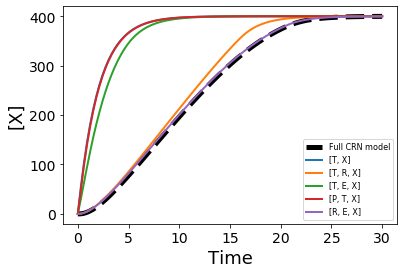

In [373]:
fig, ax = plt.subplots() 
count = 0
# params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, d_T, E_tot, P_tot, R_tot, G]
# params_values = [80, 2, 0.50, 80, 2, 0.5, 10, 2, 0.1, 0.5, 0.01, 100, 100, 400, 10]

params_values_new = [30, 2, 0.50, 80, 2, 0.5, 10, 2, 0.1, 0.5, 0.01, 100, 100, 400, 0.1]
sys.params_values = params_values_new
sys.x_init[0] = params_values_new[-3]
sys.x_init[3] = params_values_new[-2]
sys.x_init[5] = params_values_new[-4]
# print(sys.x_init)
timepoints_ode = np.linspace(0,30,100)
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system().T
_ = plt.plot(timepoints_ode, np.transpose(np.array(sys.C)@sol), 'k--', label = 'Full CRN model', linewidth = 5)
for key,value in results.items():
    sys_i = key
    sys_i.params_values = params_values_new
    if P in sys_i.x:
        ind = sys_i.x.index(P)
        sys_i.x_init[ind] = params_values[-3]
    if R in sys_i.x:
        ind = sys_i.x.index(R)
        sys_i.x_init[ind] = params_values[-2]
    if E in sys_i.x:
        ind = sys_i.x.index(E)
        sys_i.x_init[ind] = params_values[-4]
    if len(sys_i.x) >=4:
        continue
    sys_i_ode = get_ODE(sys_i, timepoints_ode)
    sol_i = sys_i_ode.solve_system().T
    _ = plt.plot(timepoints_ode, np.transpose(sys_i.C@sol_i), label = str(sys_i.x), linewidth = 2)
    _ = plt.xlabel('Time', FontSize = 18)
    _ = plt.ylabel('[X]', FontSize = 18)
    _ = ax.tick_params(axis='both', which='major', labelsize=14)
    _ = plt.legend(prop={'size': 8})
    count += 1

# _ = plt.axvline(x=timepoints_ode[6], color = 'k',linestyle = ':',linewidth = 1.5)
# _ = plt.axvline(x=timepoints_ode[15], color = 'k',linestyle = ':',linewidth = 1.5)
# _ = plt.axvline(x=timepoints_ode[30], color = 'k',linestyle = ':',linewidth = 1.5)
_ = plt.savefig('RNAP_weak_mild.svg')
plt.show()


# Endonuclease binding

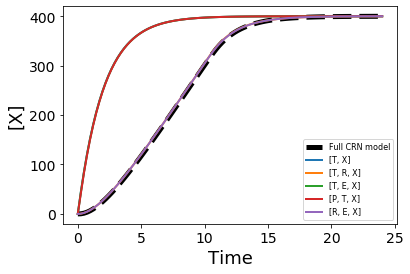

In [417]:
fig, ax = plt.subplots() 
count = 0
# params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, d_T, E_tot, P_tot, R_tot, G]
# params_values = [80, 2, 0.50, 80, 2, 0.5, 10, 2, 0.1, 0.5, 0.01, 100, 100, 400, 10]

params_values_new = [80, 2, 0.50, 80, 2, 0.5, 1, 40, 0.1, 0.5, 0.01, 100, 100, 400, 0.1]
sys.params_values = params_values_new
sys.x_init[0] = params_values_new[-3]
sys.x_init[3] = params_values_new[-2]
sys.x_init[5] = params_values_new[-4]
# print(sys.x_init)
timepoints_ode = np.linspace(0,24,100)
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system().T
_ = plt.plot(timepoints_ode, np.transpose(np.array(sys.C)@sol), 'k--', label = 'Full CRN model', linewidth = 5)
for key,value in results.items():
    sys_i = key
    sys_i.params_values = params_values_new
    if P in sys_i.x:
        ind = sys_i.x.index(P)
        sys_i.x_init[ind] = params_values[-3]
    if R in sys_i.x:
        ind = sys_i.x.index(R)
        sys_i.x_init[ind] = params_values[-2]
    if E in sys_i.x:
        ind = sys_i.x.index(E)
        sys_i.x_init[ind] = params_values[-4]
    if len(sys_i.x) >=4:
        continue
    sys_i_ode = get_ODE(sys_i, timepoints_ode)
    sol_i = sys_i_ode.solve_system().T
    _ = plt.plot(timepoints_ode, np.transpose(sys_i.C@sol_i), label = str(sys_i.x), linewidth = 2)
    _ = plt.xlabel('Time', FontSize = 18)
    _ = plt.ylabel('[X]', FontSize = 18)
    _ = ax.tick_params(axis='both', which='major', labelsize=14)
    _ = plt.legend(prop={'size': 8})
    count += 1

# _ = plt.axvline(x=timepoints_ode[6], color = 'k',linestyle = ':',linewidth = 1.5)
# _ = plt.axvline(x=timepoints_ode[15], color = 'k',linestyle = ':',linewidth = 1.5)
# _ = plt.axvline(x=timepoints_ode[30], color = 'k',linestyle = ':',linewidth = 1.5)
_ = plt.savefig('endo_weak_strict.svg')
plt.show()


(5.5, -0.5)

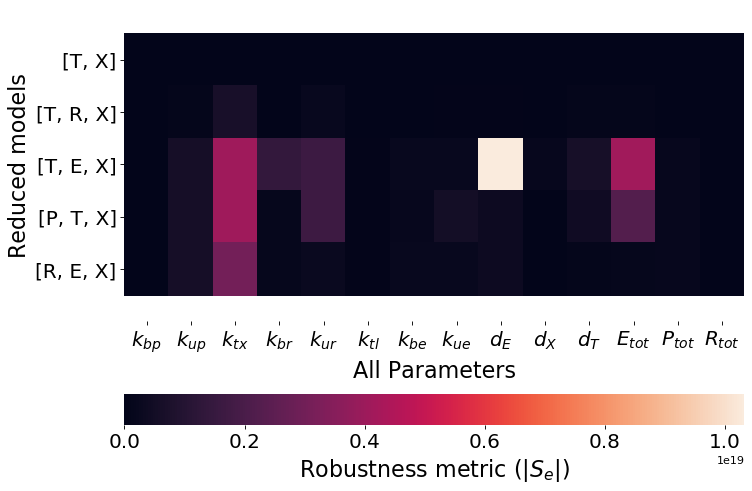

In [34]:
# fig, ax = plt.subplots() 
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# count = 0
import seaborn as sn
# params_names = ['$'+str(i)+'$' for i in params]
params_names = ['$k_{bp}$', '$k_{up}$', '$k_{tx}$', '$k_{br}$', '$k_{ur}$', '$k_{tl}$',
                '$k_{be}$', '$k_{ue}$', '$d_E$',
                 '$d_X$', '$d_T$', '$E_{tot}$', '$P_{tot}$', '$R_{tot}$']

rob_2d_all = []
rob_2d = []
sys_reduced_x = []
# plt.plot(timepoints_ode, np.transpose(np.array(sys_reduce.C)@sol), 'k--', label = 'Full CRN model', linewidth = 5)
# params_names[0] = '$k_b$'
for key,value in results.items():
    sys_i = key
    Se = value[1]
    Se = np.delete(Se, [14])
    if len(sys_i.x) >= 4:
        continue
    sys_reduced_x.append(str(sys_i.x))
    rob_2d.append(Se)
# rob_2d = [ Se_x, Se_tx, Se_rx, Se_px]
sn_ax = sn.heatmap(np.array(rob_2d), cbar_kws={'label': 'Robustness metric ($\|S_e\|$)', 
                                               'orientation':'horizontal','fraction':0.2,
                                               })

# cbar_axes = sn_ax.figure.axes[-1]
sn_ax.figure.axes[-1].xaxis.label.set_size(20)
ax = fig.axes
_ = plt.xlabel('All Parameters', FontSize = 20)
_ = plt.ylabel('Reduced models', FontSize = 20)
_ = ax[0].tick_params(axis='x', which='major', labelsize=18)
_ = ax[0].tick_params(axis='y', which='major', labelsize=18)
_ = ax[0].set_xticklabels(params_names)
_ = ax[1].tick_params(axis = 'x', labelsize = 18)
bottom, top = ax[0].get_ylim()
ax[0].set_ylim(bottom + 0.5, top - 0.5)
_ = ax[0].set_yticklabels(sys_reduced_x, rotation = 0)
# h.set_rotation(0)
_ = plt.savefig('robustness_with_all.svg')
plt.show()

(5.5, -0.5)

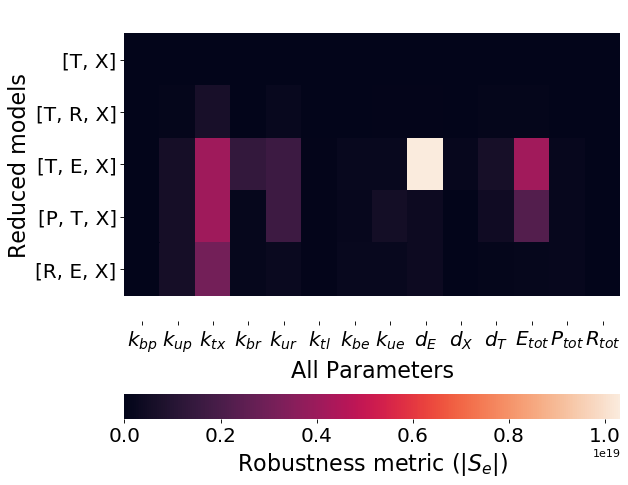

In [35]:
# fig, ax = plt.subplots() 
fig = plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
# count = 0
import seaborn as sn
# params_names = ['$'+str(i)+'$' for i in params]
params_names = ['$k_{bp}$', '$k_{up}$', '$k_{tx}$', '$k_{br}$', '$k_{ur}$', '$k_{tl}$',
                '$k_{be}$', '$k_{ue}$', '$d_E$',
                 '$d_X$', '$d_T$', '$E_{tot}$', '$P_{tot}$', '$R_{tot}$']
# params_names = ['$k_{bp}$', '$k_{up}$', '$k_{tx}$', '$k_{ur}$',
#                 '$k_{be}$', '$k_{ue}$', '$d_E$',
#                  '$d_T$', '$E_{tot}$', '$P_{tot}$']

rob_2d_all = []
rob_2d = []
sys_reduced_x = []
# plt.plot(timepoints_ode, np.transpose(np.array(sys_reduce.C)@sol), 'k--', label = 'Full CRN model', linewidth = 5)
# params_names[0] = '$k_b$'
for key,value in results.items():
    sys_i = key
    Se = value[1]
    Se = np.delete(Se, [14])

    if len(sys_i.x) >= 4:
        continue
    sys_reduced_x.append(str(sys_i.x))
    rob_2d.append(Se)
# rob_2d = [ Se_x, Se_tx, Se_rx, Se_px]
sn_ax = sn.heatmap(np.array(rob_2d), cbar_kws={'label': 'Robustness metric ($\|S_e\|$)', 
                                               'orientation':'horizontal','fraction':0.2,
                                               })

# cbar_axes = sn_ax.figure.axes[-1]
sn_ax.figure.axes[-1].xaxis.label.set_size(20)
ax = fig.axes
_ = plt.xlabel('All Parameters', FontSize = 20)
_ = plt.ylabel('Reduced models', FontSize = 20)
_ = ax[0].tick_params(axis='x', which='major', labelsize=18)
_ = ax[0].tick_params(axis='y', which='major', labelsize=18)
_ = ax[0].set_xticklabels(params_names)
_ = ax[1].tick_params(axis = 'x', labelsize = 18)
bottom, top = ax[0].get_ylim()
ax[0].set_ylim(bottom + 0.5, top - 0.5)
_ = ax[0].set_yticklabels(sys_reduced_x, rotation = 0)
# h.set_rotation(0)
_ = plt.savefig('robustness_except_ktl.svg')
plt.show()

In [383]:
len(results[list(results.keys())[0]][1])

15